<a href="https://colab.research.google.com/github/massimocipressi/MLPNS_MCipressi/blob/main/generativeAI/superresolve_aenc_faces_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K


In [3]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [4]:
cd /content/gdrive/MyDrive/MPLNS2023


/content/gdrive/MyDrive/MPLNS2023


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [ ]:
!ls 

faces95        spm-20210427T111354Z-001.zip  wine.data
HiggsBoson     transformer_h1_history	     wine.data.1
KaggleTitanic  transformer_h1_model.h5	     wine.names
model.png      transformer_h4_history	     wine.names.1
spm	       transformer_h4_model.h5


In [ ]:
flist = glob.glob("faces95/*/*jpg")

In [ ]:
N = len(flist)
N

1441


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

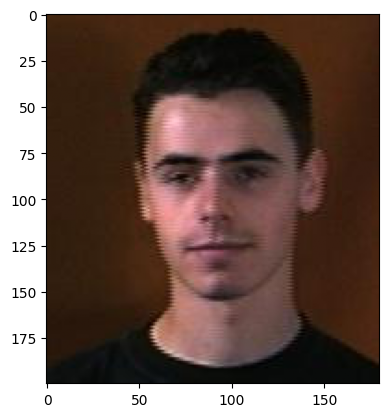

In [ ]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

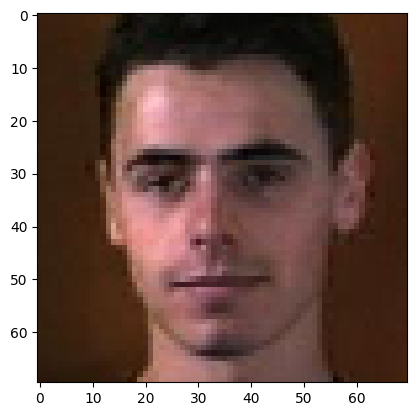

In [ ]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [ ]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-10-8d7a10a391be>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1441 [00:00<?, ?it/s]

In [ ]:
np.save("faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [5]:
imgs = np.load("faces_saved.npy")
imgs.shape

(1441, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [6]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [7]:
# lower the resolution
# imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_orig = imgs_orig[:, :-6, :-6, :]
imgs_orig.shape
imgs_lr = imgs_orig[:,::2,::2]
imgs_lr.shape

(1441, 32, 32, 1)

In [8]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1024, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [9]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)
  

In [10]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 32, 32, 1), (289, 32, 32, 1), (1152, 64, 64, 1), (289, 64, 64, 1))

#Costruiamo un convolutional auto-encoder

In [12]:
model = Sequential()

#encoder
model.add(Conv2D(512,kernel_size=(3,3),padding="same",activation="relu",
                             input_shape=(32,32,1),kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(256,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2,2)))

#decoder
model.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(256,kernel_size=(3,3),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,kernel_size=(3,3),padding="same",activation="sigmoid",
                             kernel_regularizer=keras.regularizers.l2(0.001)))

model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 512)       5120      
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 256)       1179904   
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       147584    
                                                      

## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=8,
                         min_delta=0.001)

In [ ]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])

Epoch 1/100
72/72 [==============================] - 7s 41ms/step - loss: 0.3775 - mae: 0.1250 - acc: 0.0034 - val_loss: 0.1188 - val_mae: 0.0823 - val_acc: 0.0046
Epoch 2/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0894 - mae: 0.0813 - acc: 0.0053 - val_loss: 0.0689 - val_mae: 0.0783 - val_acc: 0.0045
Epoch 3/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0568 - mae: 0.0702 - acc: 0.0053 - val_loss: 0.0478 - val_mae: 0.0680 - val_acc: 0.0046
Epoch 4/100
72/72 [==============================] - 2s 35ms/step - loss: 0.0424 - mae: 0.0674 - acc: 0.0053 - val_loss: 0.0368 - val_mae: 0.0638 - val_acc: 0.0047
Epoch 5/100
72/72 [==============================] - 2s 35ms/step - loss: 0.0342 - mae: 0.0671 - acc: 0.0053 - val_loss: 0.0308 - val_mae: 0.0667 - val_acc: 0.0046
Epoch 6/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0287 - mae: 0.0658 - acc: 0.0053 - val_loss: 0.0262 - val_mae: 0.0635 - val_acc: 0.0047
Epoch 7/100
72/7

In [ ]:
model.save("data/Convolutional.h5")

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("data/Convolutional.h5")

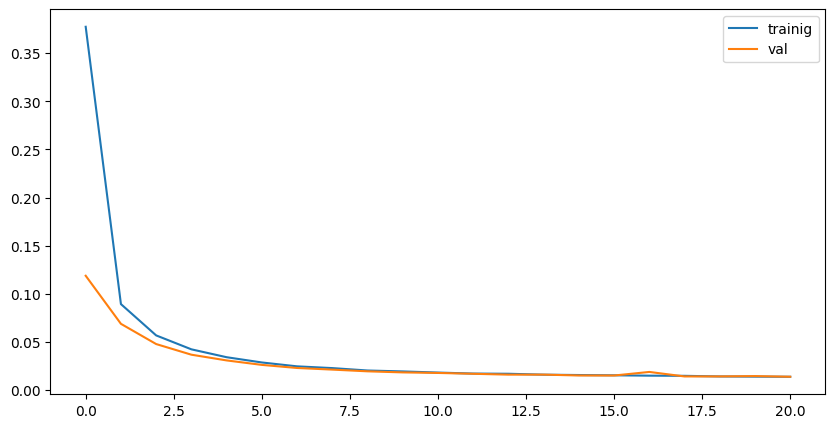

In [ ]:
plt.plot(history.history["loss"],label="trainig")
plt.plot(history.history["val_loss"],label="val")
plt.legend()


In [ ]:
#rispetto al precedente abbiamo eliminato l'overfit
#tuttavia abbiamo imparato tutto nelle prime epoche e poi si è fermato

## predict

In [ ]:
outim = model.predict(X_te)
outim.shape

10/10 [==============================] - 0s 18ms/step


(289, 64, 64, 1)

In [20]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i] , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i] , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i] , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


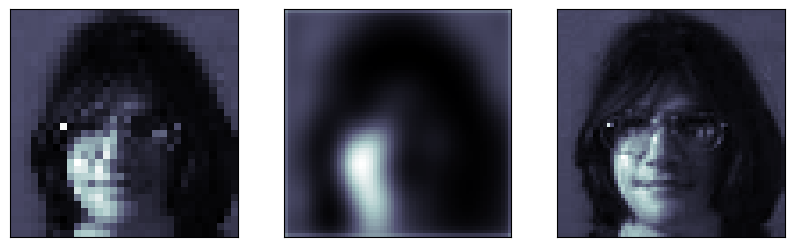

2 :	input		      prediction		  target


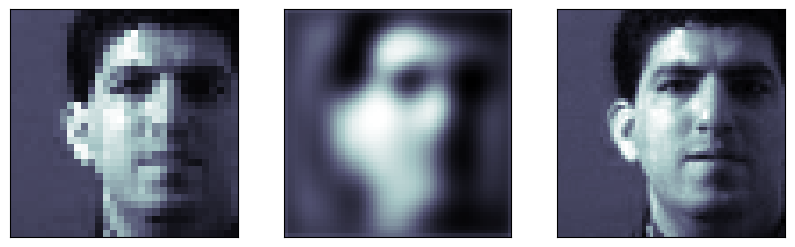

3 :	input		      prediction		  target


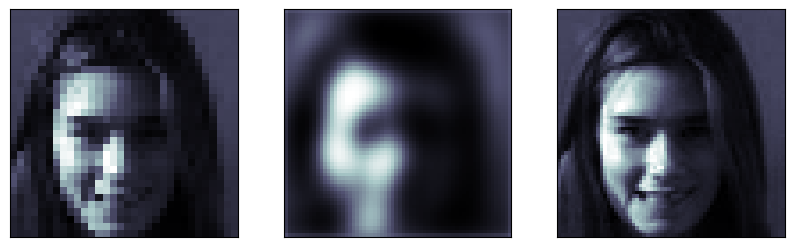

4 :	input		      prediction		  target


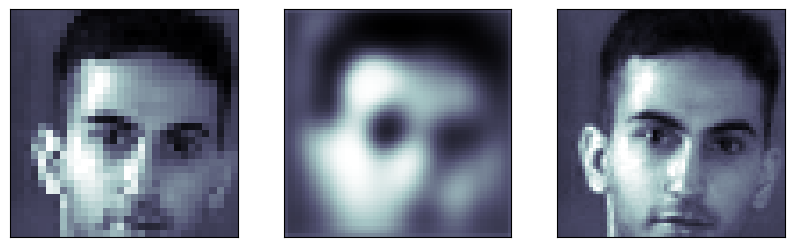

5 :	input		      prediction		  target


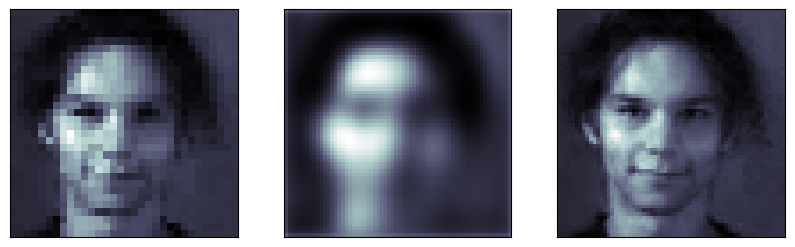

6 :	input		      prediction		  target


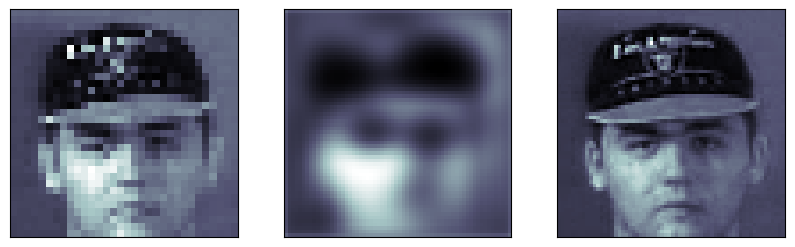

7 :	input		      prediction		  target


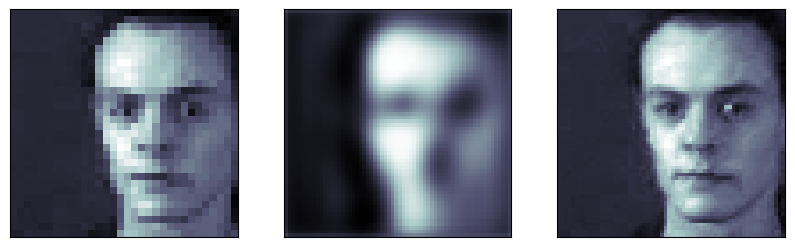

8 :	input		      prediction		  target


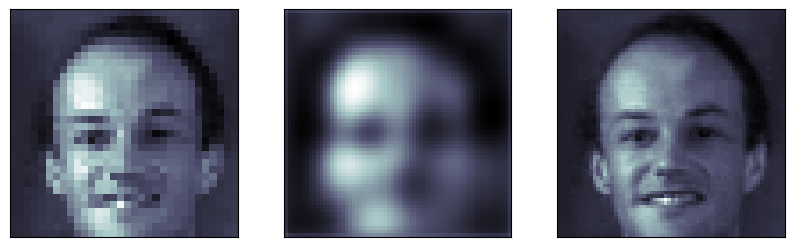

9 :	input		      prediction		  target


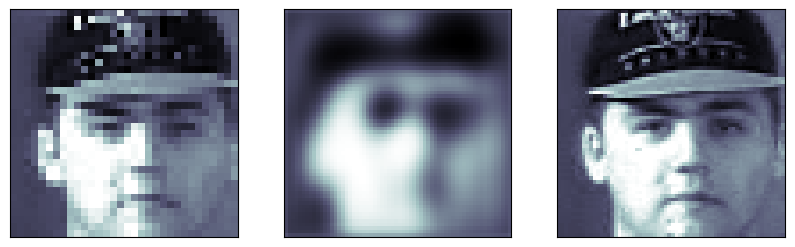

10 :	input		      prediction		  target


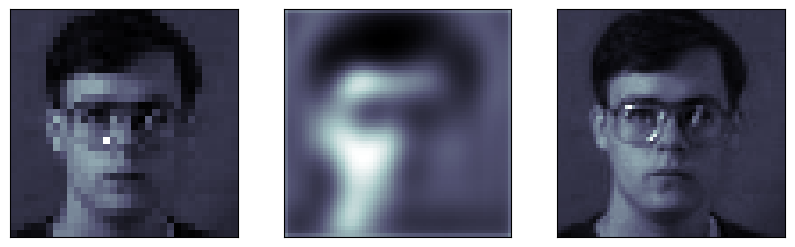

In [ ]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

In [ ]:
#terribile risultato i visi sono sfocati

In [24]:
#proviamo a cambiare optimizer aumentandogli il learning rate
#e anche a scalare la kernel size insieme all'immagine
#nel fare quest'ultima cosa però passiamo da 2,5 a 4 milioni di parametri

model_2 = Sequential()

#encoder
model_2.add(Conv2D(512,kernel_size=(4,4),padding="same",activation="relu",
                             input_shape=(32,32,1),kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(Conv2D(256,kernel_size=(4,4),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(Conv2D(128,kernel_size=(4,4),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(MaxPooling2D((2,2)))

#decoder
model_2.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(Conv2D(128,kernel_size=(3,3),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(UpSampling2D((2,2)))
model_2.add(Conv2D(128,kernel_size=(4,4),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(UpSampling2D((2,2)))
model_2.add(Conv2D(256,kernel_size=(4,4),padding="same",activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.001)))
model_2.add(UpSampling2D((2,2)))
model_2.add(Conv2D(1,kernel_size=(5,5),padding="same",activation="sigmoid",
            kernel_regularizer=keras.regularizers.l2(0.001)))

optim = keras.optimizers.Adadelta(learning_rate=0.01)

model_2.compile(optimizer="adadelta", loss="mse",
              metrics=['mae', 'acc'])

In [25]:
print(model_2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 32, 32, 512)       8704      
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 256)       2097408   
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 128)       524416    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 128)       147584    
                                                      

In [26]:
from keras.callbacks import EarlyStopping
callback_2 = EarlyStopping(monitor='val_loss',
                         patience=10,
                         min_delta=0.0001)
history_2 = model_2.fit( X_tr, y_tr, epochs=100, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback_2])

Epoch 1/100
72/72 [==============================] - 12s 102ms/step - loss: 1.4096 - mae: 0.2559 - acc: 1.8692e-04 - val_loss: 1.4087 - val_mae: 0.2547 - val_acc: 2.7033e-04
Epoch 2/100
72/72 [==============================] - 7s 96ms/step - loss: 1.4091 - mae: 0.2556 - acc: 1.8268e-04 - val_loss: 1.4081 - val_mae: 0.2544 - val_acc: 2.6948e-04
Epoch 3/100
72/72 [==============================] - 7s 96ms/step - loss: 1.4085 - mae: 0.2553 - acc: 1.8268e-04 - val_loss: 1.4075 - val_mae: 0.2540 - val_acc: 2.6948e-04
Epoch 4/100
72/72 [==============================] - 7s 99ms/step - loss: 1.4079 - mae: 0.2549 - acc: 1.8268e-04 - val_loss: 1.4069 - val_mae: 0.2536 - val_acc: 2.6948e-04
Epoch 5/100
72/72 [==============================] - 7s 97ms/step - loss: 1.4073 - mae: 0.2545 - acc: 1.8268e-04 - val_loss: 1.4063 - val_mae: 0.2532 - val_acc: 2.6948e-04
Epoch 6/100
72/72 [==============================] - 7s 98ms/step - loss: 1.4066 - mae: 0.2540 - acc: 1.8268e-04 - val_loss: 1.4056 - val_

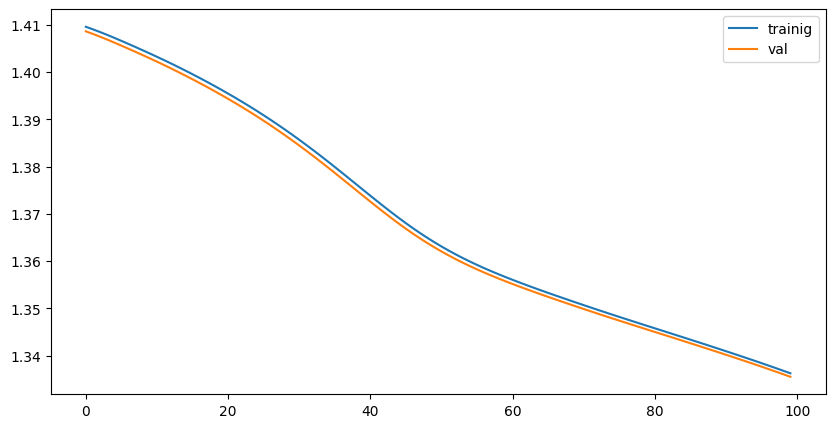

In [27]:
model_2.save("data/Convolutional_2.h5")
plt.plot(history_2.history["loss"],label="trainig")
plt.plot(history_2.history["val_loss"],label="val")
plt.legend()


In [ ]:
#facciamo proseguire il training, il risultato è già più promettente del precedente 
#e non c'è overfit

In [28]:
history_2 = model_2.fit( X_tr, y_tr, epochs=70, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback_2])

Epoch 1/70
72/72 [==============================] - 7s 103ms/step - loss: 1.3357 - mae: 0.1704 - acc: 1.8268e-04 - val_loss: 1.3350 - val_mae: 0.1687 - val_acc: 2.6948e-04
Epoch 2/70
72/72 [==============================] - 7s 103ms/step - loss: 1.3352 - mae: 0.1700 - acc: 1.8268e-04 - val_loss: 1.3344 - val_mae: 0.1683 - val_acc: 2.6948e-04
Epoch 3/70
72/72 [==============================] - 7s 104ms/step - loss: 1.3346 - mae: 0.1696 - acc: 1.8268e-04 - val_loss: 1.3339 - val_mae: 0.1679 - val_acc: 2.6948e-04
Epoch 4/70
72/72 [==============================] - 8s 105ms/step - loss: 1.3340 - mae: 0.1691 - acc: 1.8268e-04 - val_loss: 1.3333 - val_mae: 0.1675 - val_acc: 2.6948e-04
Epoch 5/70
72/72 [==============================] - 8s 106ms/step - loss: 1.3335 - mae: 0.1687 - acc: 1.8268e-04 - val_loss: 1.3327 - val_mae: 0.1670 - val_acc: 2.6948e-04
Epoch 6/70
72/72 [==============================] - 8s 107ms/step - loss: 1.3329 - mae: 0.1682 - acc: 1.8268e-04 - val_loss: 1.3321 - val_ma

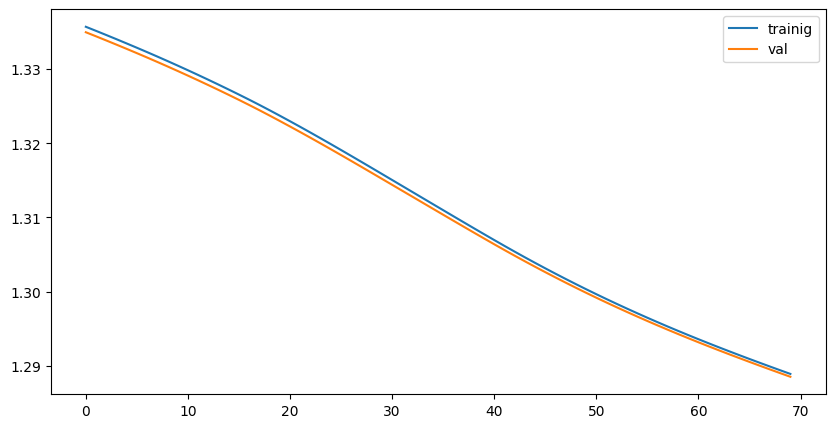

In [29]:
model_2.save("data/Convolutional_2.h5")

plt.plot(history_2.history["loss"],label="trainig")
plt.plot(history_2.history["val_loss"],label="val")
plt.legend()

10/10 [==============================] - 1s 51ms/step
1 :	input		      prediction		  target


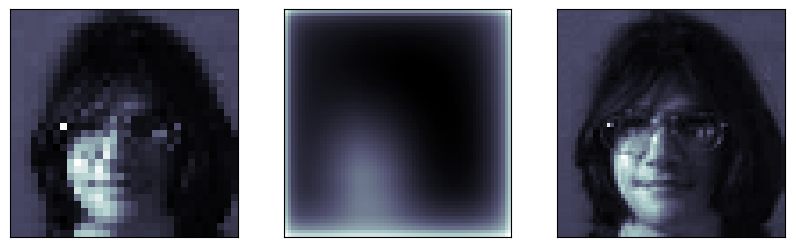

2 :	input		      prediction		  target


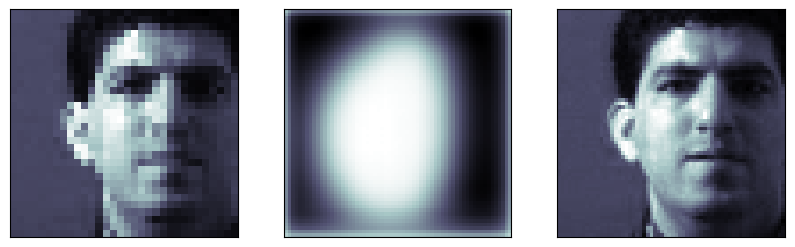

3 :	input		      prediction		  target


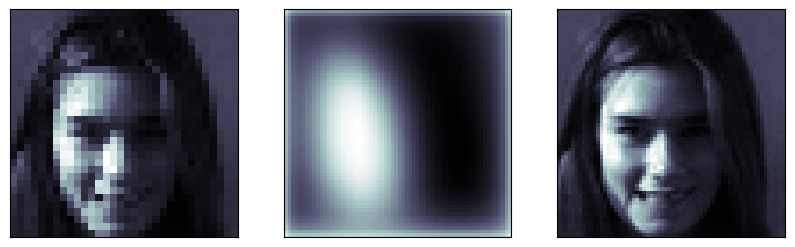

4 :	input		      prediction		  target


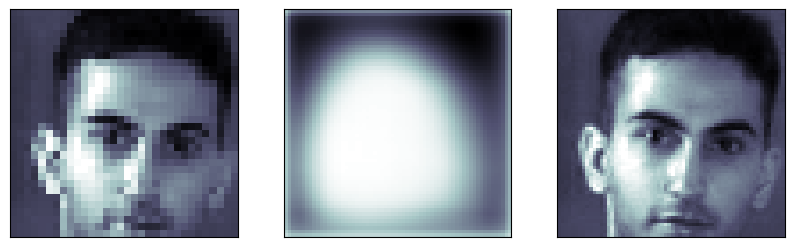

5 :	input		      prediction		  target


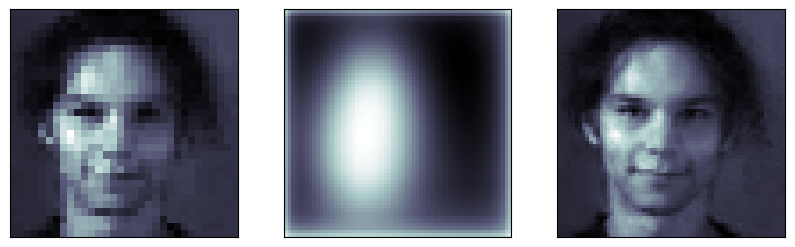

6 :	input		      prediction		  target


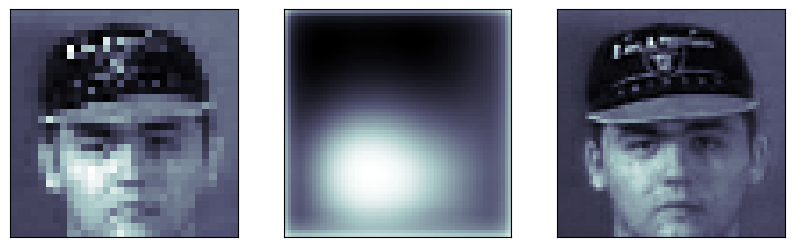

7 :	input		      prediction		  target


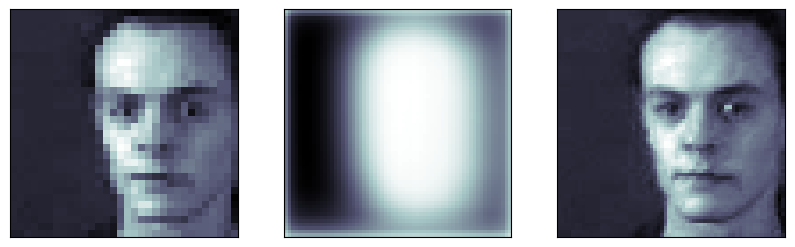

8 :	input		      prediction		  target


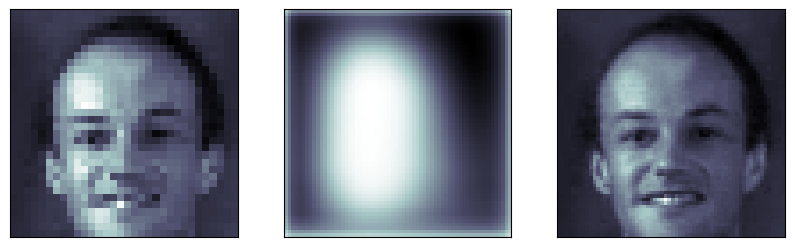

9 :	input		      prediction		  target


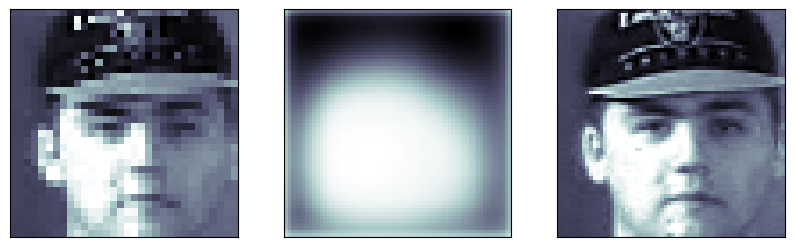

10 :	input		      prediction		  target


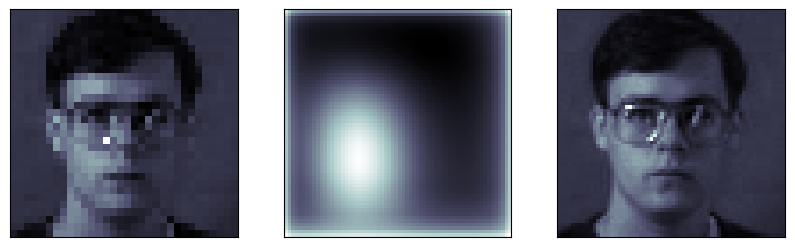

In [30]:
outim = model_2.predict(X_te)
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

In [ ]:
#peggio di prima
#dopo varie prove non si riesce a migliorare il risultato,
#sembra che funzionino meglio i layer dense che i convoloutional